<a href="https://colab.research.google.com/github/koteyevlev/Astronomy_contest/blob/master/Astronomy_contest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Загружаем данные

In [245]:
#!pip install PyDrive
#12mHyZlWqVjI4RPYr7EM9BwTi_ptw2j_
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/IDAO 2020.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()
#downloaded2 = drive.CreateFile({'id':"4/vgE_VWIwTwgnT4q89GJ8dBCj3GEzdDOwmVa4Asvj51zBM5zs_9or5y8"})
#downloaded2.GetContentFile('test.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [246]:
!unzip -q "drive/My Drive/IDAO 2020.zip"

replace IDAO 2020/Track 1/submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace IDAO 2020/Track 1/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace IDAO 2020/Track 1/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace IDAO 2020/Track 2/submission.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace IDAO 2020/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
y


In [0]:
train = pd.read_csv('IDAO 2020/train.csv')

In [0]:
test = pd.read_csv('IDAO 2020/Track 1/test.csv')

In [249]:
train.shape

(649912, 15)

In [250]:
train.tail(5)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
649907,1234089,2014-01-31T22:00:22.602,599,-21721.485878,-14048.557595,5277.807430,-1.351754,3.373418,0.004995,-20717.958996,-16245.240500,5250.939232,-1.653931,3.157321,0.079069
649908,1234090,2014-01-31T22:25:13.240,599,-23176.890569,-8712.016936,5153.371350,-0.575955,3.764450,-0.175109,-22673.444496,-11192.339393,5243.608790,-0.945328,3.603371,-0.092202
649909,1234091,2014-01-31T22:50:03.878,599,-23363.044794,-2906.071320,4747.247386,0.351381,3.992943,-0.372198,-23461.830699,-5570.167175,4966.813869,-0.087089,3.912550,-0.281989
649910,1234092,2014-01-31T23:14:54.515,599,-22058.020262,3074.894039,4038.853542,1.421085,3.984793,-0.578849,-22858.679929,373.249102,4396.055679,0.920162,4.021955,-0.485364
649911,1234093,2014-01-31T23:39:45.153,599,-19076.969715,8807.476785,3024.623998,2.587973,3.641717,-0.778817,-20656.328603,6277.934683,3518.642806,2.050990,3.844021,-0.690707


In [251]:
test.head(5)

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01T00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01T00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,1,2014-02-01T00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,1,2014-02-01T01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,1,2014-02-01T01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


Посмотрим распределение по спутникам

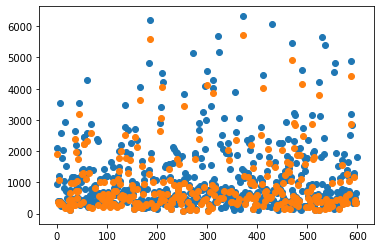

In [252]:
import matplotlib.pyplot as plt
from collections import Counter

train_sat = Counter(train.sat_id)
test_sat = Counter(test.sat_id)
plt.scatter(train_sat.keys(), train_sat.values())
plt.scatter(test_sat.keys(), test_sat.values())

Посмотрим какие спутники встречаются и в трейне и в тесте, а какие нет. Ровно половина спутников есть и в трейне и в тесте, другая половина есть только в трейне. Возможно кстати что приват борд будет по оставшимся 300.

In [253]:
print(f'Всего в трейне {len(set(train_sat))}')
print(f'Всего в тесте {len(set(test_sat))}')
print(f'Пересечений {len(set(train_sat).intersection(set(test_sat)))}')
print(f'Есть только в трейне {len(set(train_sat).difference(set(test_sat)))}')
print(f'Есть только в тесте {len(set(test_sat).difference(set(train_sat)))}')

Всего в трейне 600
Всего в тесте 300
Пересечений 300
Есть только в трейне 300
Есть только в тесте 0


Базовое решение (просто реальные=симулированным координатам)

In [254]:
submission = pd.read_csv('IDAO 2020/Track 1/submission.csv')
submission.head()

,id,x,y,z,Vx,Vy,Vz
0,3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


In [255]:
Counter(test.sat_id).most_common(5)

[(372, 5707), (186, 5601), (470, 4923), (588, 4413), (489, 4149)]

Посмотрим отклонения в трейне


In [0]:
train['epoch'] = pd.to_datetime(train['epoch'], format='%Y-%m-%dT%H:%M:%S.%f')
test['epoch'] = pd.to_datetime(test['epoch'], format='%Y-%m-%dT%H:%M:%S.%f')

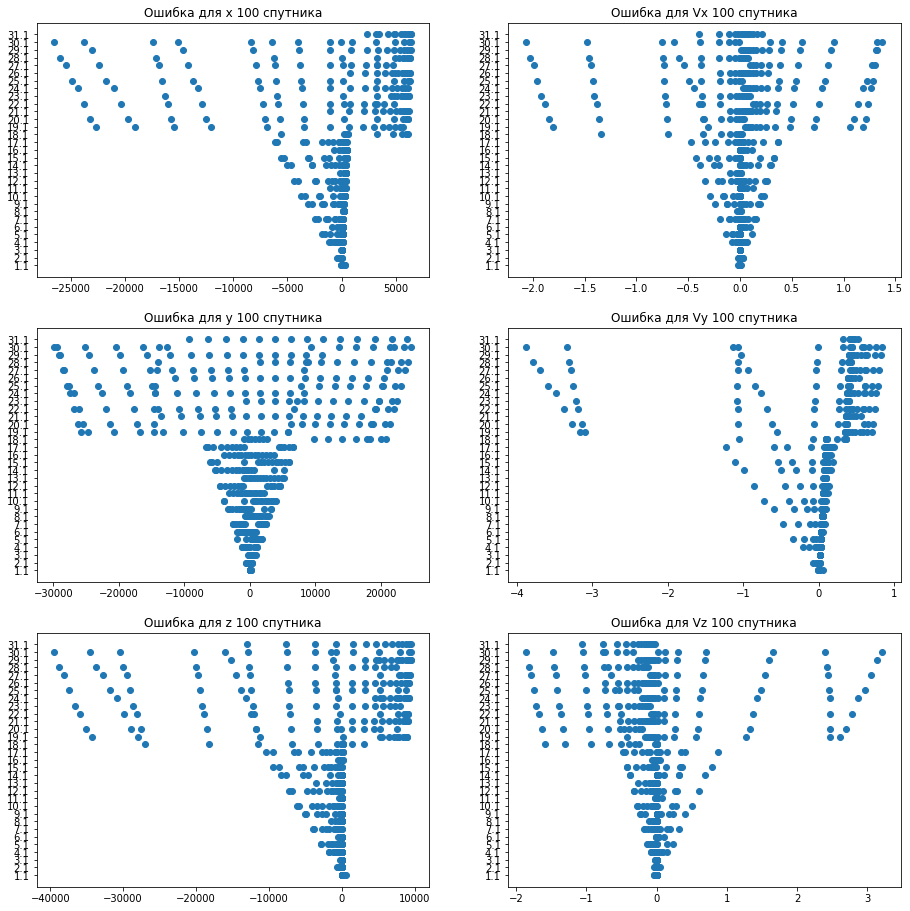

In [257]:
def plot_error(sat=0):
  fig, axs = plt.subplots(3, 2)
  plt.subplots_adjust(left=0.0, right=2.0, bottom=-2.0, top=1.0)
  lst = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
  for i in range(6):
    coord = lst[i]
    axs[i % 3, i // 3].scatter(train[train['sat_id'] == sat][coord] - train[train['sat_id'] == sat][coord + '_sim'],
                                train[train['sat_id'] == sat].epoch.dt.day.astype(str)
                                  +'.'+ train[train['sat_id'] == sat].epoch.dt.month.astype(str))
    axs[i % 3, i // 3].title.set_text('Ошибка для ' + coord + f' {sat} спутника')

plot_error(100)

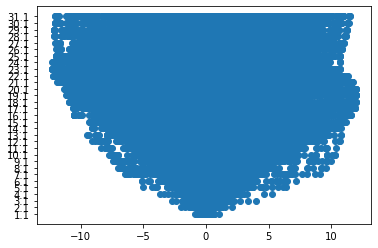

In [258]:
plt.scatter(train['Vx'] - train['Vx' + '_sim'],
                                train.epoch.dt.day.astype(str)
                                  +'.'+ train.epoch.dt.month.astype(str))

В целом медиана ошибки стремится к нулю

In [259]:
(train['y'] - train['y_sim']).describe()

count    649912.000000
mean         98.482144
std        7234.231964
min     -238458.458169
25%        -843.500219
50%           4.661291
75%         857.664350
max      205796.324370
dtype: float64

Пропусков в данных нет

In [260]:
test.isnull().sum()

id        0
sat_id    0
epoch     0
x_sim     0
y_sim     0
z_sim     0
Vx_sim    0
Vy_sim    0
Vz_sim    0
dtype: int64

Начертим 3d проекцию движения спутника. Случайно заметил интересную особенность у 100 спутника - симуляция менее четко описывает движение, предсказывая только последнюю точку.

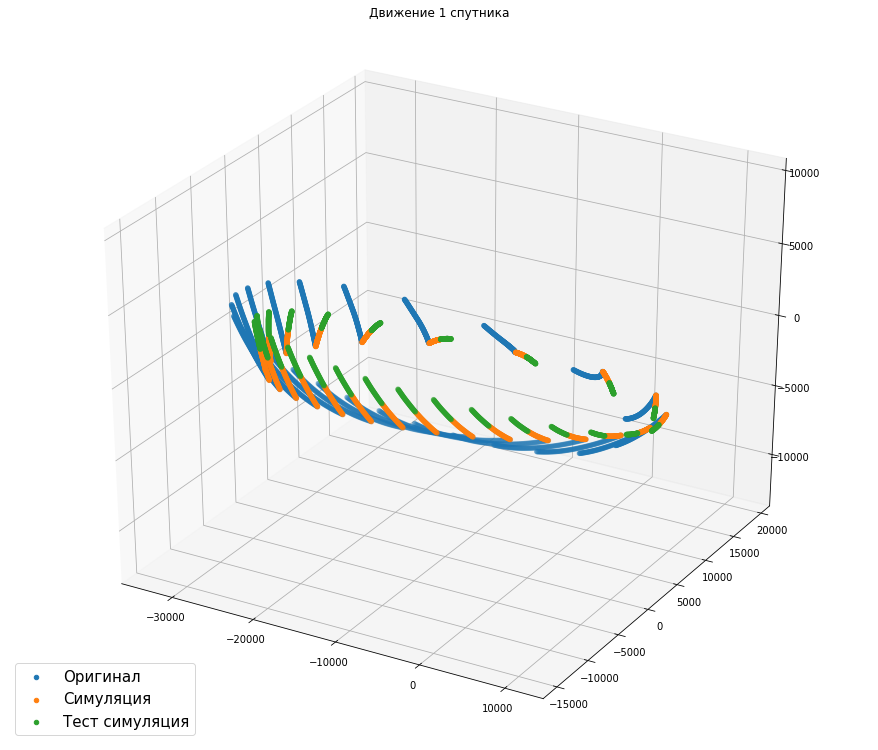

In [261]:
from mpl_toolkits.mplot3d import axes3d, Axes3D


def plot_path(sat=1):
  fig = plt.figure()
  plt.subplots_adjust(left=0.0, right=2.0, bottom=-1.5, top=1.0)
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(train[train.sat_id == sat].x, 
             train[train.sat_id == sat].y, 
             train[train.sat_id == sat].z, 
             label='Оригинал')
  ax.scatter(train[train.sat_id == sat].x_sim, 
             train[train.sat_id == sat].y_sim, 
             train[train.sat_id == sat].z_sim, 
             label='Симуляция')
  if sat in set(test_sat):
    ax.scatter(test[test.sat_id == sat].x_sim, 
               test[test.sat_id == sat].y_sim, 
               test[test.sat_id == sat].z_sim, 
               label='Тест симуляция')
  ax.legend(loc='lower left', fontsize = 15)
  ax.title.set_text(f'Движение {sat} спутника')
  plt.show()
  

plot_path(1)

Код внизу показывает траекторию для всех спутников. По нему очень хорошо видно насколько криво описывают координаты симулированные данные. 

Хорошо видно что все спутники вращаются вокруг какого то центра. Возможно у кого то они совпадут?

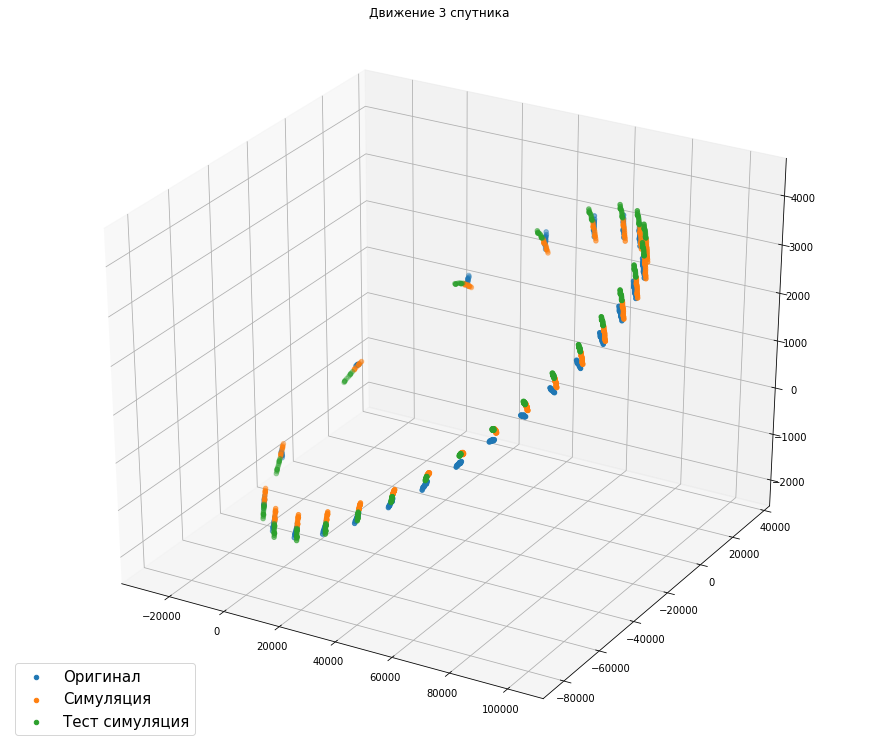

KeyboardInterrupt: ignored

In [263]:
import time
from IPython.display import clear_output


for i in set(train_sat):
  plot_path(i)
  time.sleep(3)
  clear_output()

Надо по хорошему еще посмотреть распределение по дням - похоже за один месяц спутники совершают один и более оборотов 

Теперь посмотрим на взаиморасположение спутников на какой нибудь день. Спутники достаточно сильно разбросаны - но все равно наверно есть смысл попробовать их покластеризовать(возможно по центрам вращения?)

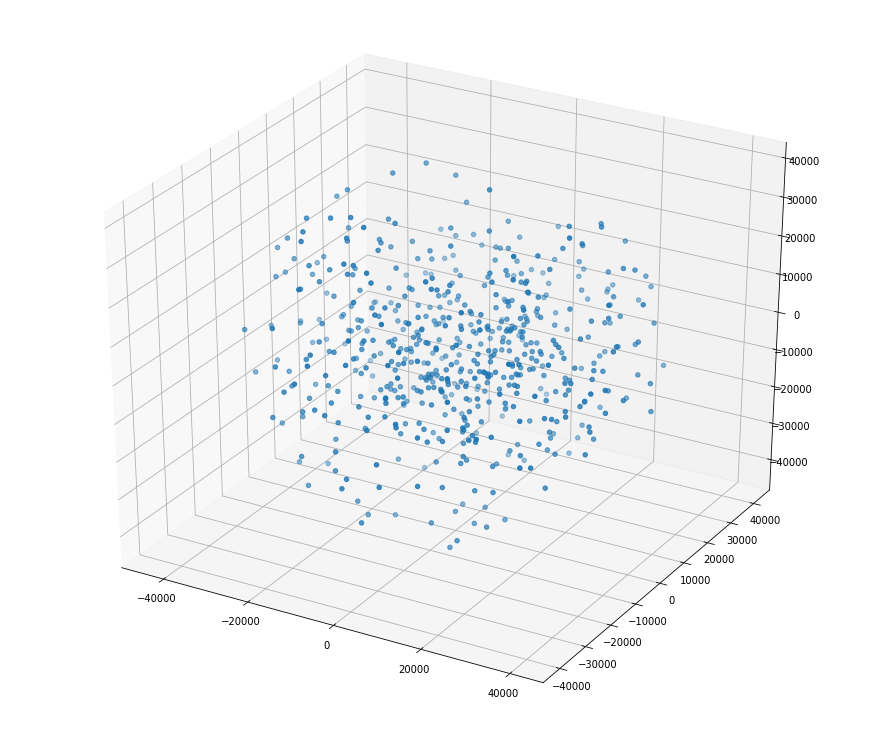

In [264]:
train["day"] = train["epoch"].dt.day
test["day"] = test["epoch"].dt.day

def plot_sat(day=1):
  all_sat = train[train.day == 1].reset_index()
  all_sat = all_sat[pd.Series(np.where(all_sat['sat_id'].duplicated(),all_sat['sat_id'], np.nan)).isnull()]
  fig = plt.figure()
  plt.subplots_adjust(left=0.0, right=2.0, bottom=-1.5, top=1.0)
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(all_sat.x, all_sat.y, all_sat.z, label='Оригинал')
  plt.show()

plot_sat()

# Делаем дополнительные фичи из данных

Есть несколько идей для фичей


Для начала вытащим все базовые временные показатели.

In [265]:
train["year"] = train["epoch"].dt.year
test["year"] = test["epoch"].dt.year
train["month"] = train["epoch"].dt.month
test["month"] = test["epoch"].dt.month
train["day"] = train["epoch"].dt.day
test["day"] = test["epoch"].dt.day
train["hour"] = train["epoch"].dt.hour
test["hour"] = test["epoch"].dt.hour
train["minute"] = train["epoch"].dt.minute
test["minute"] = test["epoch"].dt.minute
train["weekday"] = train["epoch"].dt.weekday
test["weekday"] = test["epoch"].dt.weekday
train.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,day,year,month,hour,minute,weekday
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,1,2014,1,0,0,2
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,1,2014,1,0,46,2
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,1,2014,1,1,33,2
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,1,2014,1,2,20,2
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,1,2014,1,3,6,2


Неплохо было бы сделать фичу - предыдущее расположение спутника и время до предыдущего замера. Так как в трейне и в тесте есть только симулирующие координаты, а реализовать рекурентные реальные координаты мне не очень понятно как, то пока возьмем именно симулирующие предыдущие координаты объекта.

In [266]:
train['x_sim_prev'] = train['x_sim'].shift(1)
train['y_sim_prev'] = train['y_sim'].shift(1)
train['z_sim_prev'] = train['z_sim'].shift(1)
train['Vx_sim_prev'] = train['Vx_sim'].shift(1)
train['Vy_sim_prev'] = train['Vy_sim'].shift(1)
train['Vz_sim_prev'] = train['Vz_sim'].shift(1)
train['time_from_previous'] = train.epoch - train['epoch'].shift(1) ## Эту штуку надо поправить -  он считает время и между разными спутниками
train['minute_from_previous'] = train['time_from_previous'].dt.components['minutes']
train['second_from_previous'] = train['time_from_previous'].dt.components['minutes'] * 60 
+ train['time_from_previous'].dt.components['seconds'] 
+ train['time_from_previous'].dt.components['milliseconds']/ 1000
test['x_sim_prev'] = test['x_sim'].shift(1)
test['y_sim_prev'] = test['y_sim'].shift(1)
test['z_sim_prev'] = test['z_sim'].shift(1)
test['Vx_sim_prev'] = test['Vx_sim'].shift(1)
test['Vy_sim_prev'] = test['Vy_sim'].shift(1)
test['Vz_sim_prev'] = test['Vz_sim'].shift(1)
test['time_from_previous'] = test.epoch - test['epoch'].shift(1)
test['minute_from_previous'] = test['time_from_previous'].dt.components['minutes']
test['second_from_previous'] = test['time_from_previous'].dt.components['minutes'] * 60 
+ test['time_from_previous'].dt.components['seconds']
+ test['time_from_previous'].dt.components['milliseconds']/ 1000
#train = train.fillna(np.inf)
train.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,day,year,month,hour,minute,weekday,x_sim_prev,y_sim_prev,z_sim_prev,Vx_sim_prev,Vy_sim_prev,Vz_sim_prev,time_from_previous,minute_from_previous,second_from_previous
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,1,2014,1,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,1,2014,1,0,46,2,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,00:46:43,46.0,2760.0
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,1,2014,1,1,33,2,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,00:46:43.001000,46.0,2760.0
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,1,2014,1,2,20,2,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,00:46:43,46.0,2760.0
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,1,2014,1,3,6,2,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,00:46:43.001000,46.0,2760.0


Надо будет в тест потом добавить как то реальные предыдущие координаты, да и в валидацию как то тоже

Попробую еще добавить estimation координаты при неизменной скорости(возможно стоит брать взвешенную от предыдущих скоростей?). Тоесть у нас есть предыдущие координаты, предыдущая скорость и у нас есть количество секунд между наблюдениями - соответственно из этого можно расчетную координату прибытия как --  

предыдущая координата + (предыдущая скорость + текущая)/ 2 * секунды.

In [267]:
train['estimated_x'] =  (train.Vx_sim_prev + train.Vx_sim) * train.second_from_previous / 2 + train.x_sim_prev
train['estimated_y'] =  (train.Vy_sim_prev + train.Vy_sim) * train.second_from_previous / 2 + train.y_sim_prev
train['estimated_z'] =  (train.Vz_sim_prev + train.Vz_sim) * train.second_from_previous / 2 + train.z_sim_prev
test['estimated_x'] =  (test.Vx_sim_prev + train.Vx_sim) * test.second_from_previous / 2 + test.x_sim_prev
test['estimated_y'] =  (test.Vy_sim_prev + train.Vy_sim) * test.second_from_previous / 2 + test.y_sim_prev
test['estimated_z'] =  (test.Vz_sim_prev + train.Vz_sim) * test.second_from_previous / 2 + test.z_sim_prev
train.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,day,year,month,hour,minute,weekday,x_sim_prev,y_sim_prev,z_sim_prev,Vx_sim_prev,Vy_sim_prev,Vz_sim_prev,time_from_previous,minute_from_previous,second_from_previous,estimated_x,estimated_y,estimated_z
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,1,2014,1,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,1,2014,1,0,46,2,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,00:46:43,46.0,2760.0,-10514.629240,1995.072310,-24385.645945
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,1,2014,1,1,33,2,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,00:46:43.001000,46.0,2760.0,-10595.276278,-9827.623756,-24331.915577
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,1,2014,1,2,20,2,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,00:46:43,46.0,2760.0,-9209.360995,-20388.285728,-20908.007190
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,1,2014,1,3,6,2,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,00:46:43.001000,46.0,2760.0,-6801.110650,-28757.192213,-15161.469440


Видимо это приближение слишком простое и поэтому дает значительное отклонение

Введем фичу - растояние до земли (или по другому до точки 0,0,0)

In [270]:
train['distance to Earth'] = (train.x_sim ** 2 + train.y_sim ** 2 + train.z_sim ** 2) ** 0.5
train.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,day,year,month,hour,minute,weekday,x_sim_prev,y_sim_prev,z_sim_prev,Vx_sim_prev,Vy_sim_prev,Vz_sim_prev,time_from_previous,minute_from_previous,second_from_previous,estimated_x,estimated_y,estimated_z,distance to Earth
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,1,2014,1,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,26096.521772
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,1,2014,1,0,46,2,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,00:46:43,46.0,2760.0,-10514.629240,1995.072310,-24385.645945,26703.386480
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,1,2014,1,1,33,2,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,00:46:43.001000,46.0,2760.0,-10595.276278,-9827.623756,-24331.915577,28351.260474
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,1,2014,1,2,20,2,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,00:46:43,46.0,2760.0,-9209.360995,-20388.285728,-20908.007190,30659.611188
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,1,2014,1,3,6,2,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,00:46:43.001000,46.0,2760.0,-6801.110650,-28757.192213,-15161.469440,33247.520541


# Готовим фичи и фитим модель

# Делаем предсказание на тесте и загружаем ответы в файл